In [1]:
# Setup
import importlib
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import pickle as pkl
import matplotlib.pyplot as plt
from sccoda.util import cell_composition_data as dat
from sccoda.util import data_visualization as viz

import sccoda.datasets as scd

from sccoda.model.scCODA_model import EricaModel

### Loading Data

In [2]:
# Read data into pandas from csv

cell_counts = scd.haber()

print(cell_counts)

            Mouse  Endocrine  Enterocyte  Enterocyte.Progenitor  Goblet  Stem  \
0       Control_1         36          59                    136      36   239   
1       Control_2          5          46                     23      20    50   
2       Control_3         45          98                    188     124   250   
3       Control_4         26         221                    198      36   131   
4  H.poly.Day10_1         42          71                    203     147   271   
5  H.poly.Day10_2         40          57                    383     170   321   
6   H.poly.Day3_1         52          75                    347      66   323   
7   H.poly.Day3_2         65         126                    115      33    65   
8          Salm_1         37         332                    113      59    90   
9          Salm_2         32         373                    116      67   117   

    TA  TA.Early  Tuft  
0  125       191    18  
1   11        40     5  
2  155       365    33  
3  130  

### Converting data to anndata object

In [3]:
# Convert data to anndata object
data_all = dat.from_pandas(cell_counts, covariate_columns=["Mouse"])

# Extract condition from mouse name and add it as an extra column to the covariates
data_all.obs["Condition"] = data_all.obs["Mouse"].str.replace(r"_[0-9]", "", regex=True)
print(data_all)

AnnData object with n_obs × n_vars = 10 × 8
    obs: 'Mouse', 'Condition'


In [4]:

# Select control and salmonella data
data_salm = data_all[data_all.obs["Condition"].isin(["Control", "Salm"])]
print(data_salm.obs)


       Mouse Condition
0  Control_1   Control
1  Control_2   Control
2  Control_3   Control
3  Control_4   Control
8     Salm_1      Salm
9     Salm_2      Salm


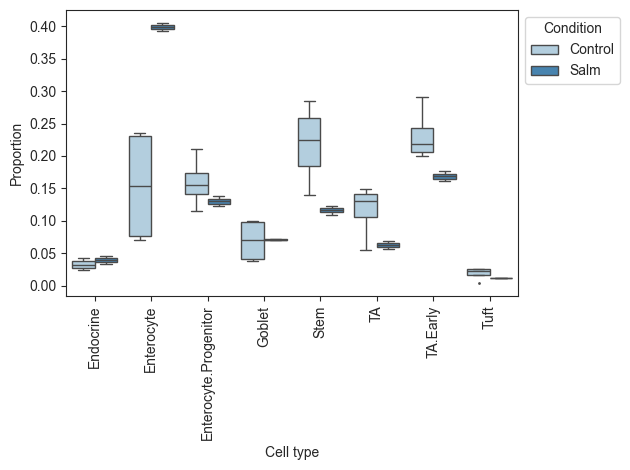

In [5]:
viz.boxplots(data_salm, feature_name="Condition")
plt.show()

### Building Design Matrix for Covariate

In [14]:
import patsy as pt

covariate_matrix_full = pt.dmatrix("Condition", data_salm.obs)
covariate_matrix=covariate_matrix_full[:,1:]
covariate_names = ["Condition"]  

In [7]:
import numpy as np

ref_index = list(data_salm.var.index).index("Goblet")

model_salm = EricaModel(
    reference_cell_type=ref_index,
    data_matrix=data_salm.X.astype("float64"),
    covariate_matrix=np.array(covariate_matrix),
    cell_types=list(data_salm.var.index),
    covariate_names=covariate_names,
    formula="Condition"
)


We first run the default parameters as a baseline.

In [8]:
# Run HMC sampling
sim_results = model_salm.sample_hmc(
    num_results=5000,  
    num_burnin=1000,
    step_size=0.01,
    num_leapfrog_steps=10
)

# Summary
print(sim_results.summary())


  0%|          | 0/5000 [00:00<?, ?it/s]2025-09-20 11:52:00.906761: I external/local_xla/xla/service/service.cc:163] XLA service 0x2a700c320 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
2025-09-20 11:52:00.906780: I external/local_xla/xla/service/service.cc:171]   StreamExecutor device (0): Host, Default Version
2025-09-20 11:52:01.025001: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1758365521.747423 9688616 device_compiler.h:196] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
100%|██████████| 5000/5000 [00:13<00:00, 365.47it/s]


MCMC sampling finished. (19.589 sec)
Acceptance rate: 56.9%
Compositional Analysis summary:

Data: 6 samples, 8 cell types
Reference index: 3
Formula: Condition

Intercepts:
                       Final Parameter  Expected Sample
Cell Type                                              
Endocrine                        1.089        34.739995
Enterocyte                       2.307       117.435778
Enterocyte.Progenitor            2.489       140.877627
Goblet                           1.721        65.358769
Stem                             2.664       167.819940
TA                               2.078        93.400025
TA.Early                         2.829       197.925682
Tuft                             0.400        17.442184


Effects:
                                 Final Parameter  Expected Sample  \
Covariate Cell Type                                                 
Condition Endocrine                      0.00000        24.784197   
          Enterocyte                     1.34968

We now run EricaModel 6 different times, changing one default parameter for each run. First, we begin by changing the mean of the alpha random variable (the intercept for the GLM) to 1.0. We then change the standard deviation of the alpha random variable to 2.0. We then change the sigma parameter (which controls the magnitude of the raw effect) to 0.5. We also alter the gamma random variable (drawn from Normal distribution which controls sign and magnitude of the raw effect). First, we change the mean from 0.0 to 0 and then the standard deviation from 1.0 to 0.5. Finaly, we change the log-odds scale from 50.0 to 25. 

In [9]:
default_priors = {
    "alpha_loc": 0.0,
    "alpha_sd": 5.0,
    "sigma_hc_scale": 1.0,
    "gamma_loc": 0.0,
    "gamma_sd": 1.0,
    "tau_temperature": 50.0
}

# Each dict changes only one prior from the default
priors_list = [
    {**default_priors, "alpha_loc": 1.0},           
    {**default_priors, "alpha_sd": 2.0},            
    {**default_priors, "sigma_hc_scale": 0.5},      
    {**default_priors, "gamma_loc": 0.5},           
    {**default_priors, "gamma_sd": 0.5},            
    {**default_priors, "tau_temperature": 25.0}     
]

results = []

for i, priors in enumerate(priors_list, 1):
    print(f"\n=== Running model with prior {i}/{len(priors_list)} ===\n")
    
    model = EricaModel(
        reference_cell_type=0,
        data_matrix=data_salm.X.astype("float64"),
        covariate_matrix=covariate_matrix,
        cell_types=list(data_salm.var.index),
        covariate_names=covariate_names,
        formula="Condition",
        **priors  
    )
    
    # Run HMC sampling
    sample_result = model.sample_hmc(num_results=5000, num_burnin=1000)
    results.append(sample_result)
    
    # Print summary of the last run
    print(sample_result.summary())



=== Running model with prior 1/6 ===



100%|██████████| 5000/5000 [00:12<00:00, 392.71it/s]


MCMC sampling finished. (17.905 sec)
Acceptance rate: 59.1%
Compositional Analysis summary:

Data: 6 samples, 8 cell types
Reference index: 0
Formula: Condition

Intercepts:
                       Final Parameter  Expected Sample
Cell Type                                              
Endocrine                        1.244        36.649712
Enterocyte                       2.395       115.862665
Enterocyte.Progenitor            2.591       140.950049
Goblet                           1.766        61.769244
Stem                             2.780       170.273431
TA                               2.191        94.481643
TA.Early                         2.929       197.631772
Tuft                             0.498        17.381485


Effects:
                                 Final Parameter  Expected Sample  \
Covariate Cell Type                                                 
Condition Endocrine                      0.00000        26.111790   
          Enterocyte                     1.36314

100%|██████████| 5000/5000 [00:13<00:00, 365.03it/s]


MCMC sampling finished. (19.003 sec)
Acceptance rate: 36.0%
Compositional Analysis summary:

Data: 6 samples, 8 cell types
Reference index: 0
Formula: Condition

Intercepts:
                       Final Parameter  Expected Sample
Cell Type                                              
Endocrine                        1.061        36.546498
Enterocyte                       2.169       110.673603
Enterocyte.Progenitor            2.463       148.500059
Goblet                           1.535        58.708549
Stem                             2.556       162.973133
TA                               2.014        94.782554
TA.Early                         2.796       207.179457
Tuft                             0.212        15.636147


Effects:
                                 Final Parameter  Expected Sample  \
Covariate Cell Type                                                 
Condition Endocrine                      0.00000        25.095557   
          Enterocyte                     1.49124

100%|██████████| 5000/5000 [00:13<00:00, 369.74it/s]


MCMC sampling finished. (18.739 sec)
Acceptance rate: 52.1%
Compositional Analysis summary:

Data: 6 samples, 8 cell types
Reference index: 0
Formula: Condition

Intercepts:
                       Final Parameter  Expected Sample
Cell Type                                              
Endocrine                        1.147        36.307414
Enterocyte                       2.323       117.686223
Enterocyte.Progenitor            2.503       140.895990
Goblet                           1.672        61.376189
Stem                             2.685       169.020830
TA                               2.095        93.692858
TA.Early                         2.845       198.347781
Tuft                             0.427        17.672716


Effects:
                                 Final Parameter  Expected Sample  \
Covariate Cell Type                                                 
Condition Endocrine                     0.000000        25.978143   
          Enterocyte                    1.340545

100%|██████████| 5000/5000 [00:12<00:00, 391.02it/s]


MCMC sampling finished. (18.264 sec)
Acceptance rate: 57.8%
Compositional Analysis summary:

Data: 6 samples, 8 cell types
Reference index: 0
Formula: Condition

Intercepts:
                       Final Parameter  Expected Sample
Cell Type                                              
Endocrine                        1.187        37.801299
Enterocyte                       2.310       116.203559
Enterocyte.Progenitor            2.508       141.647768
Goblet                           1.642        59.581401
Stem                             2.682       168.568715
TA                               2.103        94.475777
TA.Early                         2.848       199.007690
Tuft                             0.429        17.713791


Effects:
                                 Final Parameter  Expected Sample  \
Covariate Cell Type                                                 
Condition Endocrine                     0.000000        26.225445   
          Enterocyte                    1.428333

100%|██████████| 5000/5000 [00:15<00:00, 317.96it/s]


MCMC sampling finished. (20.936 sec)
Acceptance rate: 58.7%
Compositional Analysis summary:

Data: 6 samples, 8 cell types
Reference index: 0
Formula: Condition

Intercepts:
                       Final Parameter  Expected Sample
Cell Type                                              
Endocrine                        1.172        36.584630
Enterocyte                       2.344       118.111397
Enterocyte.Progenitor            2.518       140.559125
Goblet                           1.690        61.413410
Stem                             2.704       169.292539
TA                               2.119        94.313866
TA.Early                         2.858       197.478204
Tuft                             0.420        17.246828


Effects:
                                 Final Parameter  Expected Sample  \
Covariate Cell Type                                                 
Condition Endocrine                     0.000000        26.256293   
          Enterocyte                    1.329973

100%|██████████| 5000/5000 [00:13<00:00, 376.11it/s]


MCMC sampling finished. (18.415 sec)
Acceptance rate: 53.2%
Compositional Analysis summary:

Data: 6 samples, 8 cell types
Reference index: 0
Formula: Condition

Intercepts:
                       Final Parameter  Expected Sample
Cell Type                                              
Endocrine                        1.184        36.683224
Enterocyte                       2.342       116.783235
Enterocyte.Progenitor            2.526       140.375297
Goblet                           1.707        61.887581
Stem                             2.713       169.240288
TA                               2.128        94.284756
TA.Early                         2.871       198.208504
Tuft                             0.446        17.537116


Effects:
                                 Final Parameter  Expected Sample  \
Covariate Cell Type                                                 
Condition Endocrine                     0.000000        25.990329   
          Enterocyte                    1.371597

In [18]:
priors = default_priors.copy()
priors["tau_temperature"] = 5.0

model = EricaModel(
        reference_cell_type=0,
        data_matrix=data_salm.X.astype("float64"),
        covariate_matrix=covariate_matrix,
        cell_types=list(data_salm.var.index),
        covariate_names=covariate_names,
        formula="Condition",
        **priors
    )

# Run HMC sampling
sample_result = model.sample_hmc(num_results=5000, num_burnin=1000)
results.append(sample_result)
    

print(sample_result.summary())


100%|██████████| 5000/5000 [00:13<00:00, 373.69it/s]


MCMC sampling finished. (20.203 sec)
Acceptance rate: 54.5%
Compositional Analysis summary:

Data: 6 samples, 8 cell types
Reference index: 0
Formula: Condition

Intercepts:
                       Final Parameter  Expected Sample
Cell Type                                              
Endocrine                        1.167        36.779588
Enterocyte                       2.323       116.856072
Enterocyte.Progenitor            2.498       139.204354
Goblet                           1.688        61.926180
Stem                             2.702       170.706042
TA                               2.114        94.816460
TA.Early                         2.846       197.145695
Tuft                             0.428        17.565610


Effects:
                                 Final Parameter  Expected Sample  \
Covariate Cell Type                                                 
Condition Endocrine                     0.000000        26.233497   
          Enterocyte                    1.353918